In [1]:
from keras.models import load_model
from model import *
from deepseg_gm import *
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from keras import Model
import imgaug as ia
import imgaug.augmenters as iaa
import math
import random

In [2]:
'''
Normalize volume to mean ~= 0 and std ~= 1
@input: volume to be normalized
@return: normalized volume
'''
def vol_norm(volume):
    """This method will enable the function call for the
        class object.

        :param volume: the volume to be normalized.
        """
    volume_mean = volume.mean()
    volume_std = volume.std()

    volume = volume.astype('float32')
    volume -= volume_mean
    volume /= volume_std

    return volume

### Load in the data and do some testing

In [3]:
#Load in the data
train_data = np.load('data/train_data.npy')
train_targets = np.load('data/train_targets.npy')
val_data = np.load('data/val_data.npy')
val_targets = np.load('data/val_targets.npy')

## Try data augmentatiton

In [171]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases.
seq = iaa.Sequential(
    [
        # crop images by -15% to 15% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.10, 0.10),
            pad_mode=["edge"]
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.8, 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -45 to +45 degrees
            # shear=(-8, 8), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.5)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 4)), # blur image using local means with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25)), # sharpen images
                iaa.AdditiveGaussianNoise(scale=(0.0, 0.05*500)), # add gaussian noise to images
                # iaa.OneOf([
                #     iaa.Dropout((0.01, 0.1)), # randomly remove up to 10% of the pixels
                #     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05)),
                # ]),
                iaa.LinearContrast((0.5, 1.5)), # improve or worsen the contrast
                # sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                # sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

### Training Data Augmentation

In [172]:
def arr_reshape_front_dim(arr):
    arr_lst = []
    for i in range(np.shape(arr)[2]):
        arr_lst.append(np.reshape(arr[:,:,i], (1, 256, 256)))
    return np.concatenate(arr_lst, axis=0)

In [173]:
def arr_norm(arr):
    arr_lst = []
    for i in range(np.shape(arr)[0]):
        arr_lst.append(np.reshape(vol_norm(arr[i]), (1, 256, 256)))
    return np.concatenate(arr_lst, axis=0)

In [174]:
'''
Data augmentation on both the training data and targets
@data: image data
@targets: segmentation maps for the images
@multiplier: amount images augmented per image
'''
def data_and_target_aug(data, targets, multiplier=16):
    data_aug = [arr_norm(arr_reshape_front_dim(data)).astype('float32')]
    targets_aug = [arr_reshape_front_dim(targets).astype('uint8')]
    multiplier = 16
    for i in range(np.shape(data)[2]):
        # Example batch of images.
        # The array has shape (32, 64, 64, 3) and dtype uint8.
        images = np.array(
            [data[:, :, i].astype('int16') for _ in range(multiplier)],
        )

        images_seg = np.array(
            [np.reshape(targets[:, :, i].astype('uint8'), (256, 256, 1)) for _ in range(multiplier)]
        )
        
        images_aug, images_seg_aug = seq(images=images, segmentation_maps=images_seg)
        data_aug.append(arr_norm(images_aug))
        targets_aug.append(np.reshape(images_seg_aug, (multiplier, 256, 256)))

    # Concatenate the arrays
    return np.concatenate(data_aug, axis=0), np.concatenate(targets_aug, axis=0)

In [175]:
train_data_aug, train_targets_aug = data_and_target_aug(train_data, train_targets)

5107 -7.450581e-09 0.99999994


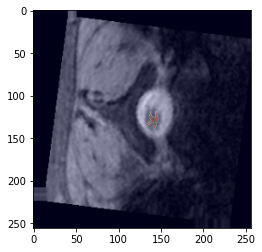

In [280]:
slice = random.randint(0, np.shape(train_data_aug)[0] - 1)
print(slice, np.mean(train_data_aug[slice]), np.std(train_data_aug[slice]))
plt.imshow(train_data_aug[slice].astype('double'), cmap='gray')
plt.imshow(train_targets_aug[slice], cmap='jet', alpha=0.2)

In [281]:
np.save('data/train_data_aug.npy', train_data_aug)
np.save('data/train_targets_aug.npy', train_targets_aug)

### Validation Data 

In [282]:
val_data_aug, val_targets_aug  = data_and_target_aug(val_data, val_targets)

897 1.0430813e-07 1.0


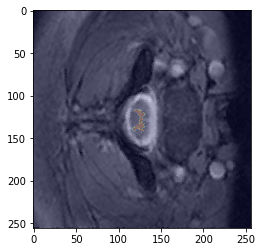

In [489]:
slice = random.randint(0, np.shape(val_data_aug)[0] - 1)
print(slice, np.mean(val_data_aug[slice]), np.std(val_data_aug[slice]))
plt.imshow(val_data_aug[slice].astype('double'), cmap='gray')
plt.imshow(val_targets_aug[slice], cmap='jet', alpha=0.2)

In [283]:
np.save('data/val_data_aug.npy', val_data_aug)
np.save('data/val_targets_aug.npy', val_targets_aug)